In [1]:
from pathlib import Path
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Encuentra la raíz del proyecto buscando carpeta "data"
ROOT = Path.cwd().resolve()
for _ in range(6):
    if (ROOT / "data").exists():
        break
    ROOT = ROOT.parent

print("CWD :", Path.cwd().resolve())
print("ROOT:", ROOT)

P_BI = ROOT / "data" / "gold" / "bicing_gold_bi.parquet"
assert P_BI.exists(), f"No existe: {P_BI}"

con = duckdb.connect()
print("DuckDB OK")
print("BI Parquet:", P_BI)


CWD : C:\Users\patxi\Documents\GitHub\bicing-barcelona-ml\notebooks\eda
ROOT: C:\Users\patxi\Documents\GitHub\bicing-barcelona-ml
DuckDB OK
BI Parquet: C:\Users\patxi\Documents\GitHub\bicing-barcelona-ml\data\gold\bicing_gold_bi.parquet


In [2]:
q = f"""
SELECT
  COUNT(*) AS n_rows,
  COUNT(DISTINCT station_id) AS n_stations,
  MIN(time_hour) AS min_time,
  MAX(time_hour) AS max_time,
  SUM(CASE WHEN (is_holiday_barcelona=1 OR is_holiday_catalunya=1 OR is_holiday_spain=1) THEN 1 ELSE 0 END) AS holiday_any_rows,
  SUM(is_holiday_barcelona) AS holiday_bcn_rows,
  SUM(is_holiday_catalunya) AS holiday_cat_rows,
  SUM(is_holiday_spain) AS holiday_es_rows
FROM read_parquet('{P_BI.as_posix()}')
"""
profile = con.execute(q).df()
profile


,n_rows,n_stations,min_time,max_time,holiday_any_rows,holiday_bcn_rows,holiday_cat_rows,holiday_es_rows
0,21140312,415,2019-03-24 14:00:00,2025-12-31 23:00:00,938966.0,127128.0,291079.0,520759.0


In [3]:
q_nulls = f"""
SELECT
  SUM(CASE WHEN bikes_available_mean IS NULL THEN 1 ELSE 0 END) AS null_bikes,
  SUM(CASE WHEN temperature_2m IS NULL THEN 1 ELSE 0 END) AS null_temp,
  SUM(CASE WHEN precipitation IS NULL THEN 1 ELSE 0 END) AS null_precip,
  SUM(CASE WHEN lag_1h_bikes IS NULL THEN 1 ELSE 0 END) AS null_lag1,
  SUM(CASE WHEN lag_24h_bikes IS NULL THEN 1 ELSE 0 END) AS null_lag24,
  SUM(CASE WHEN holiday_scope IS NULL THEN 1 ELSE 0 END) AS null_holiday_scope,
  SUM(CASE WHEN holiday_name IS NULL THEN 1 ELSE 0 END) AS null_holiday_name
FROM read_parquet('{P_BI.as_posix()}')
"""
con.execute(q_nulls).df()


,null_bikes,null_temp,null_precip,null_lag1,null_lag24,null_holiday_scope,null_holiday_name
0,0.0,0.0,0.0,1930.0,689439.0,20201346.0,20201346.0


In [4]:
q_sanity = f"""
SELECT
  SUM(CASE WHEN bikes_available_mean < 0 THEN 1 ELSE 0 END) AS neg_bikes,
  SUM(CASE WHEN docks_available_mean < 0 THEN 1 ELSE 0 END) AS neg_docks,
  SUM(CASE WHEN temperature_2m < -10 OR temperature_2m > 45 THEN 1 ELSE 0 END) AS weird_temp,
  SUM(CASE WHEN precipitation < 0 THEN 1 ELSE 0 END) AS neg_precip
FROM read_parquet('{P_BI.as_posix()}')
"""
con.execute(q_sanity).df()


,neg_bikes,neg_docks,weird_temp,neg_precip
0,83.0,0.0,0.0,0.0


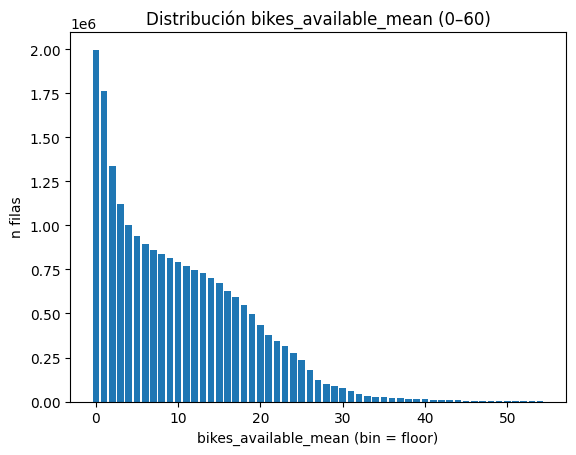

In [5]:
q_hist = f"""
WITH x AS (
  SELECT bikes_available_mean AS b
  FROM read_parquet('{P_BI.as_posix()}')
  WHERE b IS NOT NULL
)
SELECT
  FLOOR(b) AS bin,
  COUNT(*) AS n
FROM x
WHERE b BETWEEN 0 AND 60
GROUP BY 1
ORDER BY 1
"""
hist_df = con.execute(q_hist).df()

plt.figure()
plt.bar(hist_df["bin"], hist_df["n"])
plt.title("Distribución bikes_available_mean (0–60)")
plt.xlabel("bikes_available_mean (bin = floor)")
plt.ylabel("n filas")
plt.show()


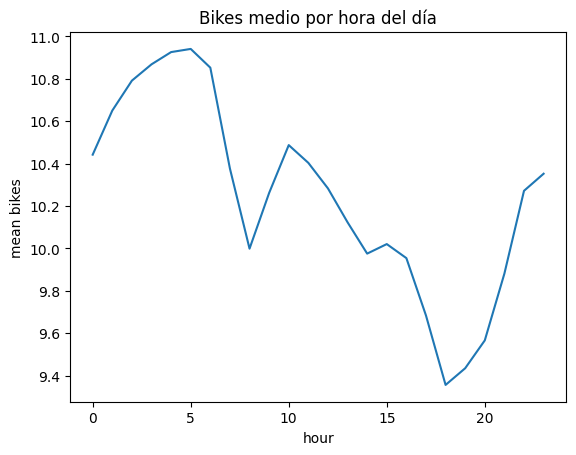

In [6]:
q_hour = f"""
SELECT hour, AVG(bikes_available_mean) AS mean_bikes
FROM read_parquet('{P_BI.as_posix()}')
GROUP BY 1
ORDER BY 1
"""
by_hour = con.execute(q_hour).df()

plt.figure()
plt.plot(by_hour["hour"], by_hour["mean_bikes"])
plt.title("Bikes medio por hora del día")
plt.xlabel("hour")
plt.ylabel("mean bikes")
plt.show()


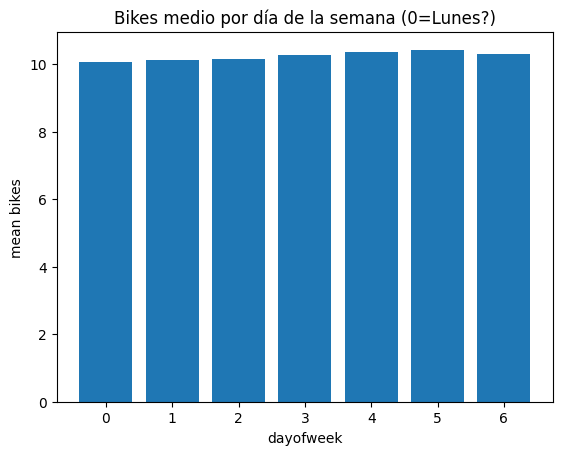

In [7]:
q_dow = f"""
SELECT dayofweek, AVG(bikes_available_mean) AS mean_bikes
FROM read_parquet('{P_BI.as_posix()}')
GROUP BY 1
ORDER BY 1
"""
by_dow = con.execute(q_dow).df()

plt.figure()
plt.bar(by_dow["dayofweek"], by_dow["mean_bikes"])
plt.title("Bikes medio por día de la semana (0=Lunes?)")
plt.xlabel("dayofweek")
plt.ylabel("mean bikes")
plt.show()


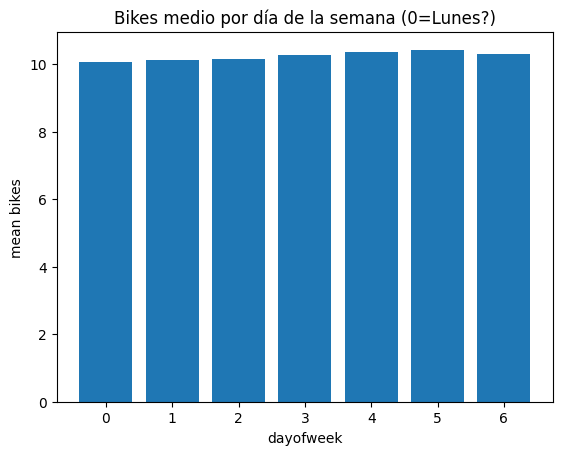

In [8]:
q_dow = f"""
SELECT dayofweek, AVG(bikes_available_mean) AS mean_bikes
FROM read_parquet('{P_BI.as_posix()}')
GROUP BY 1
ORDER BY 1
"""
by_dow = con.execute(q_dow).df()

plt.figure()
plt.bar(by_dow["dayofweek"], by_dow["mean_bikes"])
plt.title("Bikes medio por día de la semana (0=Lunes?)")
plt.xlabel("dayofweek")
plt.ylabel("mean bikes")
plt.show()


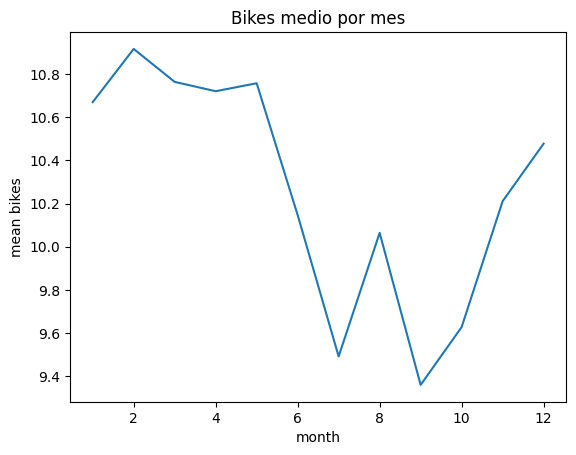

In [9]:
q_month = f"""
SELECT month, AVG(bikes_available_mean) AS mean_bikes
FROM read_parquet('{P_BI.as_posix()}')
GROUP BY 1
ORDER BY 1
"""
by_month = con.execute(q_month).df()

plt.figure()
plt.plot(by_month["month"], by_month["mean_bikes"])
plt.title("Bikes medio por mes")
plt.xlabel("month")
plt.ylabel("mean bikes")
plt.show()


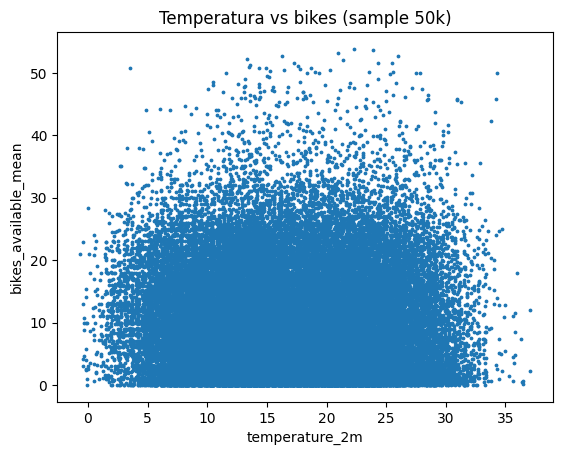

In [10]:
q_sample = f"""
SELECT
  bikes_available_mean,
  temperature_2m,
  precipitation,
  wind_speed_10m
FROM read_parquet('{P_BI.as_posix()}')
USING SAMPLE 50000 ROWS
"""
s = con.execute(q_sample).df()

plt.figure()
plt.scatter(s["temperature_2m"], s["bikes_available_mean"], s=3)
plt.title("Temperatura vs bikes (sample 50k)")
plt.xlabel("temperature_2m")
plt.ylabel("bikes_available_mean")
plt.show()


In [11]:
q_hol = f"""
WITH base AS (
  SELECT
    bikes_available_mean,
    CASE
      WHEN is_holiday_barcelona=1 THEN 'barcelona'
      WHEN is_holiday_catalunya=1 THEN 'catalunya'
      WHEN is_holiday_spain=1 THEN 'spain'
      ELSE 'none'
    END AS holiday_scope_final
  FROM read_parquet('{P_BI.as_posix()}')
)
SELECT holiday_scope_final,
       COUNT(*) AS n,
       AVG(bikes_available_mean) AS mean_bikes,
       STDDEV_SAMP(bikes_available_mean) AS std_bikes
FROM base
GROUP BY 1
ORDER BY n DESC
"""
hol_stats = con.execute(q_hol).df()
hol_stats


,holiday_scope_final,n,mean_bikes,std_bikes
0,none,20201346,10.234976,8.359154
1,spain,520759,10.546171,7.722164
2,catalunya,291079,10.500608,8.112197
3,barcelona,127128,9.909538,8.389654


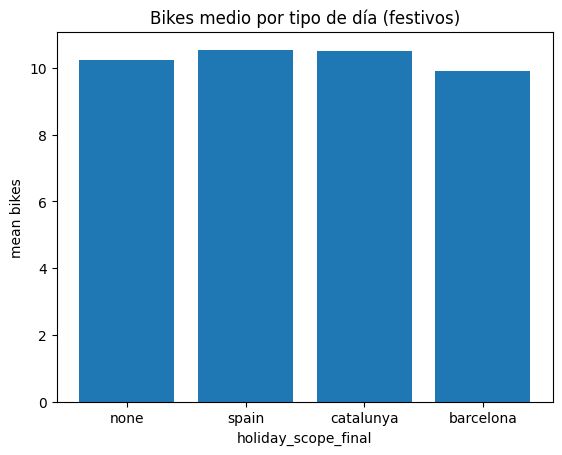

In [12]:
plt.figure()
plt.bar(hol_stats["holiday_scope_final"], hol_stats["mean_bikes"])
plt.title("Bikes medio por tipo de día (festivos)")
plt.xlabel("holiday_scope_final")
plt.ylabel("mean bikes")
plt.show()


In [13]:
q_cov = f"""
SELECT station_id, COUNT(*) AS n_rows
FROM read_parquet('{P_BI.as_posix()}')
GROUP BY 1
ORDER BY n_rows ASC
LIMIT 30
"""
con.execute(q_cov).df()


,station_id,n_rows
0,563,2119
1,573,2164
2,566,2178
3,572,2255
4,558,2284
5,608,2286
6,603,2291
7,577,2344
8,554,2351
9,597,2417


In [14]:
con.close()
print("con cerrado")


con cerrado
